In [5]:
import copy
from pathlib import Path
import random
from statistics import mean

import numpy as np
from torch import nn
from tqdm import tqdm
import torch
import timm
from easyfsl.utils import plot_images

In [6]:
random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [8]:
n_way = 3
n_shot = 1
n_query = 10

DEVICE = "cuda"
n_workers = 0

In [9]:
from easyfsl.datasets import CUB
from easyfsl.samplers import TaskSampler
from torch.utils.data import DataLoader

# 
n_tasks_per_epoch = 50
n_validation_tasks = 10

# 初始化一个dataset
train_set = CUB(split="val", training=True,image_size=224)
val_set = CUB(split="train", training=False,image_size=224)


In [10]:
# 这些是特殊的批量采样器，对具有预定义形状的少量分类任务进行采样
train_sampler = TaskSampler(
    train_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_tasks_per_epoch
)
val_sampler = TaskSampler(
    val_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_validation_tasks
)

In [11]:
# Finally, the DataLoader. We customize the collate_fn so that batches are delivered
# in the shape: (support_images, support_labels, query_images, query_labels, class_ids)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)
val_loader = DataLoader(
    val_set,
    batch_sampler=val_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=val_sampler.episodic_collate_fn,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


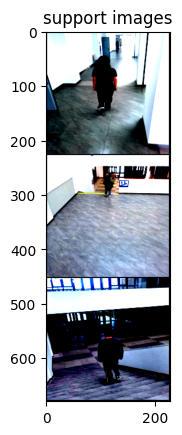

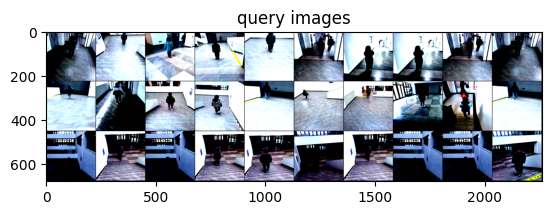

In [12]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(val_loader)) # 迭代器加载每一波数据

plot_images(example_support_images, "support images", images_per_row=n_shot)
plot_images(example_query_images, "query images", images_per_row=n_query)

然后我们定义网络。在这里，我选择了Prototypical Networks和PyTorch内置的ResNet18，因为它很容易。

In [13]:
from easyfsl.methods import PrototypicalNetworks, FewShotClassifier,RelationNetworks
from easyfsl.modules import resnet12,default_relation_module, resnet18

convolutional_network = resnet12() #初始化原型网络的主干
# convolutional_network = timm.create_model('vit_base_patch8_224', pretrained=True)

In [14]:
# convolutional_network

In [15]:
# timm.list_models()

In [16]:
convolutional_network = nn.DataParallel(convolutional_network)

In [17]:
few_shot_classifier = PrototypicalNetworks(convolutional_network).to(DEVICE) 

In [18]:
from torch.optim import SGD, Optimizer
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter


LOSS_FUNCTION = nn.CrossEntropyLoss()

n_epochs = 10
scheduler_milestones = [1, 2, 3]
scheduler_gamma = 0.1
learning_rate = 1e-4
tb_logs_dir = Path("../logs")

# train_optimizer = SGD(
#     few_shot_classifier.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4
# )
# train_scheduler = MultiStepLR(
#     train_optimizer,
#     milestones=scheduler_milestones,
#     gamma=scheduler_gamma,
# )

train_optimizer = torch.optim.Adam(
    few_shot_classifier.parameters(), lr=learning_rate, weight_decay=5e-4
)
train_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    train_optimizer,
    milestones=scheduler_milestones,
    gamma=scheduler_gamma,
)


tb_writer = SummaryWriter(log_dir=str(tb_logs_dir))

In [19]:
def training_epoch(model: FewShotClassifier, data_loader: DataLoader, optimizer: Optimizer):
    all_loss = []
    model.train()
    with tqdm(
        enumerate(data_loader), total=len(data_loader), desc="Training"
    ) as tqdm_train:
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            _,
        ) in tqdm_train:
            optimizer.zero_grad()
            model.process_support_set(
                support_images.to(DEVICE), support_labels.to(DEVICE)
            )
            classification_scores = model(query_images.to(DEVICE))

            loss = LOSS_FUNCTION(classification_scores, query_labels.to(DEVICE))
            loss.backward()
            optimizer.step()

            all_loss.append(loss.item())

            tqdm_train.set_postfix(loss=mean(all_loss))

    return mean(all_loss)

In [ ]:
from easyfsl.utils import evaluate

best_state = few_shot_classifier.state_dict()
best_validation_accuracy = 0.0
for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    average_loss = training_epoch(few_shot_classifier, train_loader, train_optimizer)
    validation_accuracy = evaluate(
        few_shot_classifier, val_loader, device=DEVICE, tqdm_prefix="Validation"
    )

    if validation_accuracy > best_validation_accuracy:
        best_validation_accuracy = validation_accuracy
        best_state = copy.deepcopy(few_shot_classifier.state_dict())
        # state_dict() returns a reference to the still evolving model's state so we deepcopy
        # https://pytorch.org/tutorials/beginner/saving_loading_models
        print("Ding ding ding! We found a new best model!")

    tb_writer.add_scalar("Train/loss", average_loss, epoch)
    tb_writer.add_scalar("Val/acc", validation_accuracy, epoch)

    # Warn the scheduler that we did an epoch
    # so it knows when to decrease the learning rate
    train_scheduler.step()

Epoch 0


Training:  24%|██▍       | 12/50 [01:06<03:21,  5.30s/it, loss=1.64]

In [16]:
few_shot_classifier.load_state_dict(best_state)

<All keys matched successfully>

## Evaluation
Now that our model is trained, we want to test it.
First step: we fetch the test data.

In [20]:
n_test_tasks = 1000

test_set = CUB(split="train", training=False,image_size=224)
test_sampler = TaskSampler(
    test_set, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_test_tasks
)
test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=n_workers,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

Second step: we run the few-shot classifier on the test data.

In [21]:
accuracy = evaluate(few_shot_classifier, test_loader, device=DEVICE)
print(f"Average accuracy : {(100 * accuracy):.2f} %")

100%|█████████████████| 1000/1000 [02:55<00:00,  5.70it/s, accuracy=0.857]

Average accuracy : 85.73 %


Congrats! You performed Episodic Training using EasyFSL. If you want to compare with a model trained using classical training, look at [this other example notebook](classical_training.ipynb).


In [22]:
new_best_checkpoint_path = '/ML/Mashuai/eye-FSL/weight/swin_s3_small_224-{:.3f}.pth'.format(accuracy)
torch.save(few_shot_classifier, new_best_checkpoint_path)

In [2]:
import timm

# 列出所有模型
models = timm.list_models()
for i in models:
    print(i)


bat_resnext26ts
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatnet_3_rw_224
coatnet_4_224
coatnet_5_224
coatnet_bn_0_rw_224
coatnet_nano_cc_224
coatnet_nano_rw_224
coatnet_pico_rw_224
coatnet_rmlp_0_rw_224
coatnet_rmlp_1_rw2_224
coatnet_rmlp_1_rw_224
coatnet_rmlp_2_rw_224
coatnet_rmlp_2_rw_384
coatnet_rmlp_3_rw_224
coatnet_rmlp_nano_rw_224
coatnext_nano_rw_224
convformer_b36
convformer_m36
convformer_s18
convformer_s36
convit_base
conv

In [2]:
for i in range(0,101):
    print(f'"./data/CUB/images/{i}",')

"./data/CUB/images/0",
"./data/CUB/images/1",
"./data/CUB/images/2",
"./data/CUB/images/3",
"./data/CUB/images/4",
"./data/CUB/images/5",
"./data/CUB/images/6",
"./data/CUB/images/7",
"./data/CUB/images/8",
"./data/CUB/images/9",
"./data/CUB/images/10",
"./data/CUB/images/11",
"./data/CUB/images/12",
"./data/CUB/images/13",
"./data/CUB/images/14",
"./data/CUB/images/15",
"./data/CUB/images/16",
"./data/CUB/images/17",
"./data/CUB/images/18",
"./data/CUB/images/19",
"./data/CUB/images/20",
"./data/CUB/images/21",
"./data/CUB/images/22",
"./data/CUB/images/23",
"./data/CUB/images/24",
"./data/CUB/images/25",
"./data/CUB/images/26",
"./data/CUB/images/27",
"./data/CUB/images/28",
"./data/CUB/images/29",
"./data/CUB/images/30",
"./data/CUB/images/31",
"./data/CUB/images/32",
"./data/CUB/images/33",
"./data/CUB/images/34",
"./data/CUB/images/35",
"./data/CUB/images/36",
"./data/CUB/images/37",
"./data/CUB/images/38",
"./data/CUB/images/39",
"./data/CUB/images/40",
"./data/CUB/images/41",
".